In [10]:
import os
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style('whitegrid')
pd.set_option('display.float_format', lambda x: '%.2f' % x)

# Set up working directory - adjust this to where the repo is stored locally
%cd '/Users/patmccornack/Documents/ucsb_fog_project/_repositories/sci-fog-analysis'

/Users/patmccornack/Documents/ucsb_fog_project/_repositories/sci-fog-analysis


# Pozo August Weekly Plots

__Author:__ Pat McCornack

__Date:__ 10/31/24

__Description:__ For each week in August, create line plots with air temp, RH, fog drip, and dew point in order to consider the relationships between the variables.

__Outputs:__  
None.


# Functions
----

## Calculations

In [11]:
def calc_dew_point(airtemp_series, rh_series):
    """
    Calculates dew point from temperature and relative humidity.

    The dew point is the temperature at which air becomes saturated with moisture and water begins to condense. 

    Parameters
    ----------
    airtemp_series : pandas.Series
        Series of temperature values.
    rh_series : pandas.Series
        Series of relative humidity values.

    Returns
    -------
        Series of dew point values.
    """
    b = 17.625
    c = 243.04

    dew_point = []
    for i in range(len(airtemp_series)):
        gamma = np.log((rh_series.iloc[i]/100)) + (b*airtemp_series.iloc[i])/(c+airtemp_series.iloc[i])
        dp = (c * gamma) / (b - gamma)

        dew_point.append(dp)

    return dew_point

def calc_dpd(airtemp_series, dewpoint_series):
    """
    Calculates the dew point depression, the difference between the air temperature and dew point. 

    Parameters
    ----------
    airtemp_series : pandas.Series
        Series of temperature values.
    dewpoint_series : pandas.Series
        Series of dew point values.

    Returns
    -------
        Series of dew point depression values.
    """
    dpd = airtemp_series - dewpoint_series

    return dpd 

## Plotting

In [12]:
def plot_week(df, title):
    """
    Create lineplot comparing air temperature, relative humidity, fog, and dew point in the same plot. Used to assess 
    the meteorological conditions during fog events.

    Parameters
    ----------
    df : pandas.DataFrame
        Dataframe with meteorological data.
    title : str
        Title for the plot.

    Returns
    -------
    None

    """
    
    # Set x axis
    xticks = df.index[::6*12]

    fig, ax = plt.subplots(figsize=(15,6))
    
    # Plot Air Temperature
    sns.lineplot(data=df['air_temp_min'],
            color='orange',
            label='Air Temp.',
            legend=False,
            ax=ax)
    ax.set_ylim(10,24)
    ax.set(ylabel='Air Temperature (C)',
           xlabel='Time')
    plt.xticks(ticks=xticks, labels=xticks, rotation=90)
    
    # Axis for relative humidity
    ax2 = ax.twinx()
    ax2.grid(False)

    # Plot Relative Humidity
    sns.lineplot(data=df['RH_min'],
                color='gray',
                label='Rel. Humidity',
                legend=False,
                ax=ax2)
    ax2.set_ylim(50,105)
    ax2.grid(False)
    ax2.set(ylabel='Relative Humidity (%)')

    # Plot Fog
    ax3 = ax.twinx()
    ax3.spines['right'].set_position(('outward', 60))  # Offset the third y-axis to the right
    ax3.set_ylim(0,120)
    sns.lineplot(data=df['fog'],
                 color='blue',
                 label='Fog Drip',
                 alpha=0.5,
                 legend=False,
                 ax=ax3)
    ax3.grid(False)
    ax3.set(ylabel='Fog Drip')

    # Plot Relative Humidity
    sns.lineplot(data=df['dew_point'],
                color='red',
                label='Dew Point',
                legend=False,
                ax=ax)

    # Gather handles and labels for all three axes
    lines, labels = ax.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    lines3, labels3 = ax3.get_legend_handles_labels()

    # Combine them and add the legend
    ax3.legend(lines + lines2 + lines3, labels + labels2 + labels3, loc='upper right')

    plt.title(title)

    plt.show()

# Main
----

In [13]:
#### Load and Pre-process Data #####

# Read in data
df_fpath = './data/03-processed/smo2-curatedfog-aug22.csv'
df = pd.read_csv(df_fpath)

# Subset to select variables 
col_subset = ['time', 'fog-harp-ml', 'fog-remove-flag', 'relative-humidity-minimum-rh-min-pct',
       'air-temperature-minimum-degc', 'barometric-pressure-average-bp-mbar-avg-mb',
       'leaf-wetness-average-l-wm-v-avg-mv',
       'rainfall-sum-rain-mm-tot-mm',
       'barometric-pressure-average-vp-mbar-avg-mb',
       'wind-speed-wind-vector-cells-ws-ms-u-wvt-ms',
        'air-temperature-wind-vector-cells-wind-dir-sdu-wvt-deg']

col_names = ['time', 'fog', 'fog_flag', 'RH_min', 'air_temp_min', 'atm_pressure',
             'leaf_wetness', 'rainfall', 'vapor_pressure', 'wind_speed_avg',
              'wind_dir']
df = df[col_subset]
df.columns = col_names
df.head()

# Create variables
df['dew_point'] = calc_dew_point(df['air_temp_min'], df['RH_min'])
df['dew_point_depression'] = calc_dpd(df['air_temp_min'], df['dew_point'])

# Drop fog_flag variable - not needed here
df.drop('fog_flag', axis=1, inplace=True)

# Label fog observations
df['condition'] = df['fog'].apply(lambda x: 'fog' if x != 0 else 'no fog')

# Set Index to time
df['time'] = pd.to_datetime(df['time'], format='%m/%d/%y %H:%M')
df.set_index('time', inplace=True, drop=False)

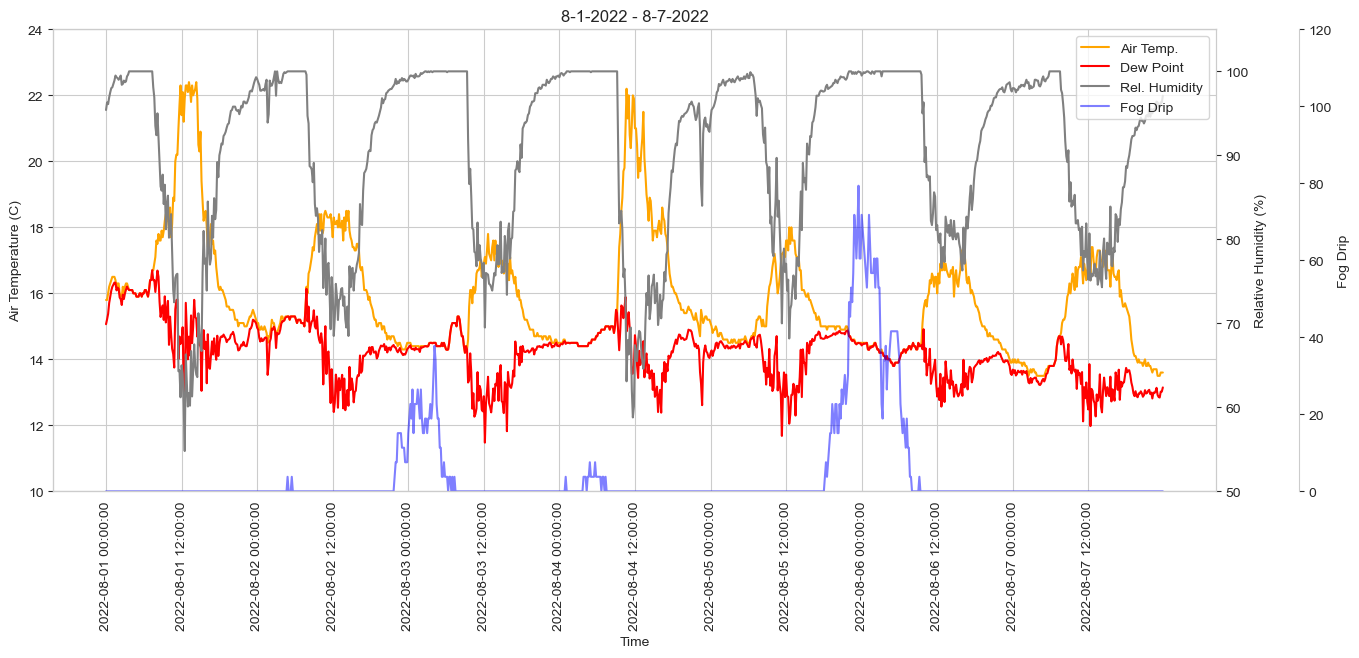

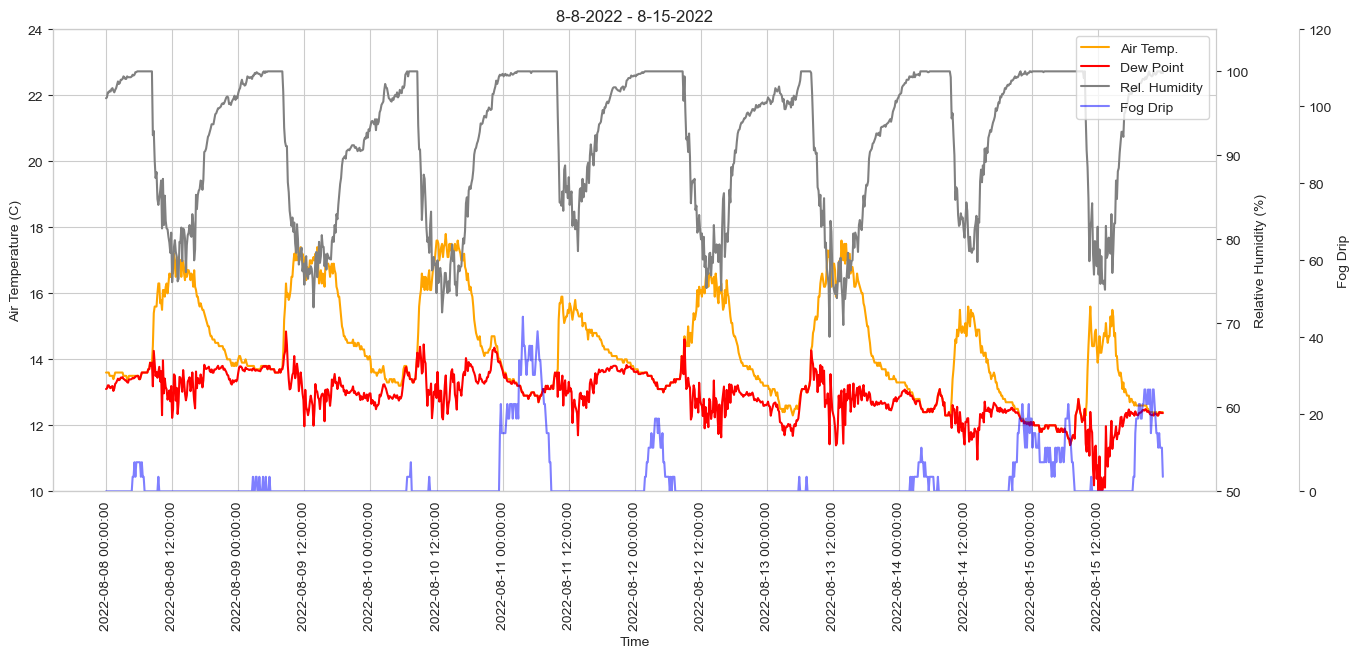

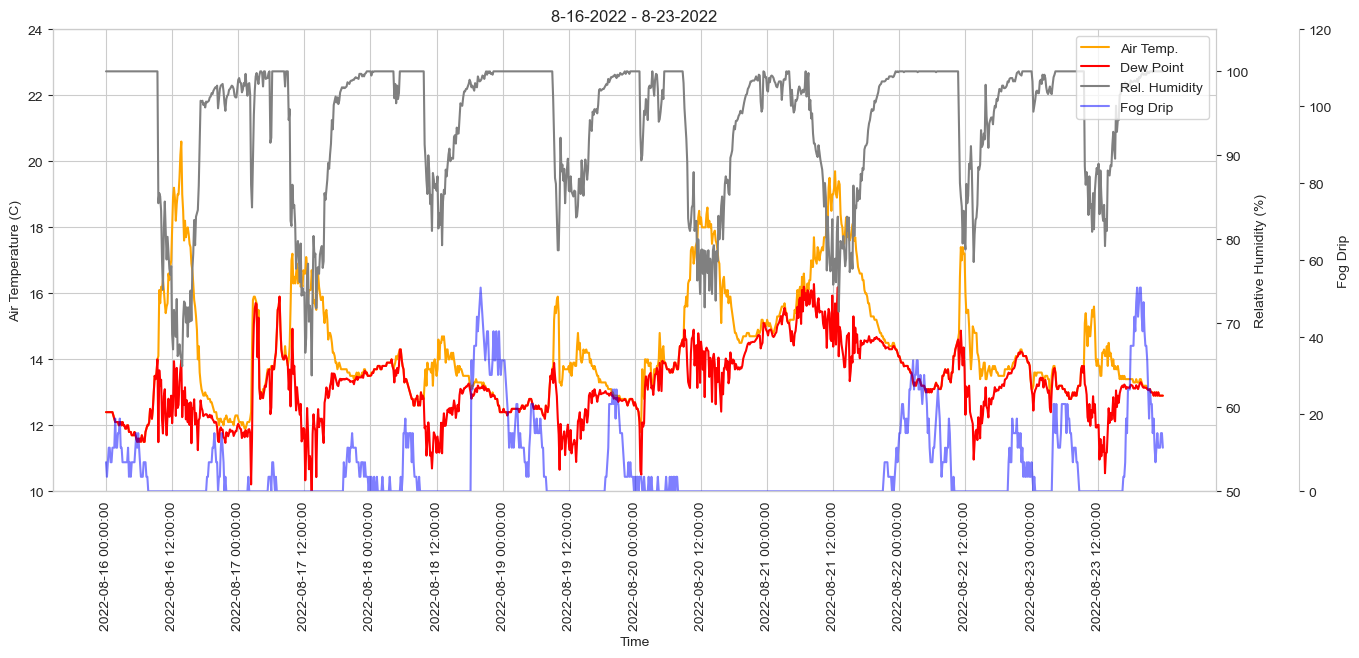

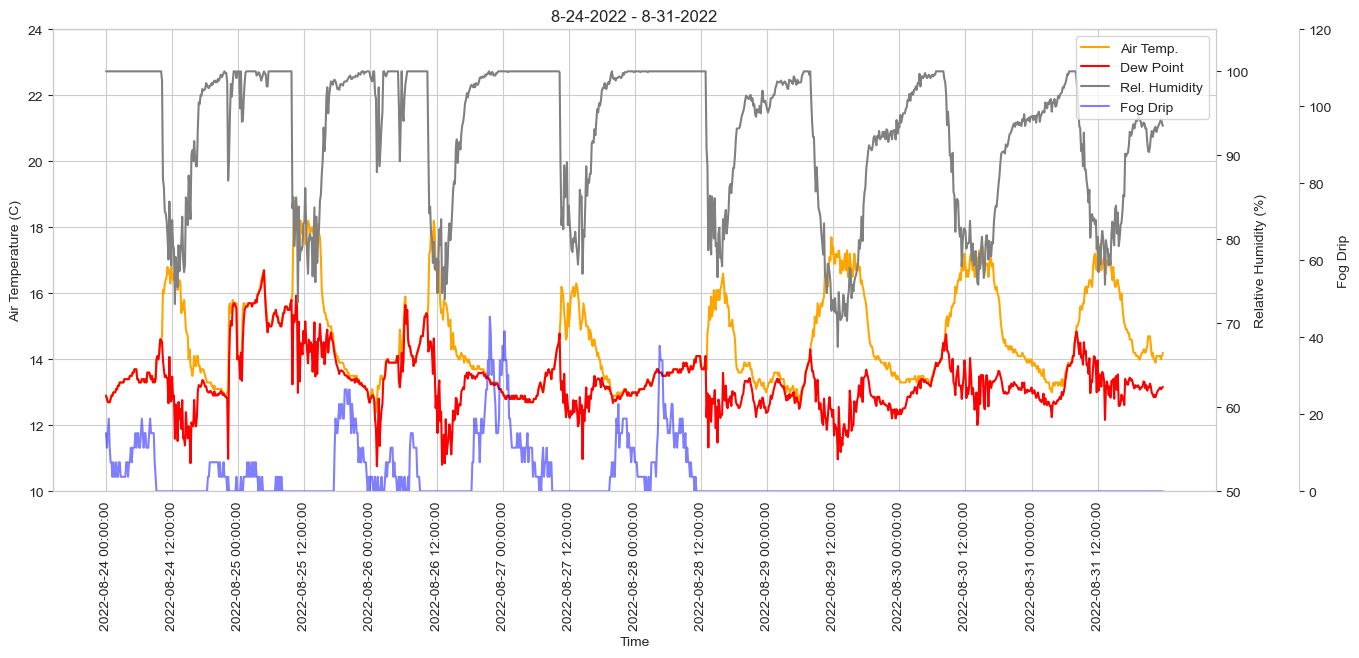

In [14]:
#### Make Plots ####
weeks = [['8-1-2022  00:00:00', '8-7-2022  23:50:00'], 
         ['8-8-2022  00:00:00', '8-15-2022  23:50:00'],
         ['8-16-2022  00:00:00', '8-23-2022  23:50:00'],
         ['8-24-2022  00:00:00', '8-31-2022  23:50:00']]

for week in weeks:
    plot_week(df=df[week[0] : week[1]],
              title=f"{week[0].split(' ')[0]} - {week[1].split(' ')[0]}")
